In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#          print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**STEP 1: IMPORT ALL THE LIBRARIES REQUIRED**

In [2]:
# import numpy as np
# import os
# import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import cv2
import tensorflow as tf
import keras
from keras import layers, Sequential
from tqdm import tqdm
from keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping,ModelCheckpoint

2024-05-05 13:35:58.898837: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 13:35:58.898952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 13:35:59.190350: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import warnings
warnings.filterwarnings('ignore')

**STEP 2: NOW LOAD THE DATASET AND EXPLORE THE DATA**

In [4]:
image_path = '/kaggle/input/emotion-recognition-dataset/dataset'
file_list = os.listdir(image_path)
df_files = pd.DataFrame(file_list, columns=['Emotions'])
df_files

,Emotions
0,Surprise
1,Angry
2,Neutral
3,Sad
4,Happy
5,Ahegao


Now, either, let's create the dataframe, if not already available; or read the dataframe using pandas 

In [5]:
## The code for reading the dataset and creating the dataframe has been commented out  

# files = [i for i in glob(image_path + "//*//*")]
# np.random.shuffle(files)
# labels = [os.path.basename(os.path.dirname(i)) for i in files]
# data = zip(files, labels)
# df = pd.DataFrame(data, columns=['Image', 'Label'])
# df

image_data = '/kaggle/input/emotion-recognition-dataset/data.csv'
data = pd.read_csv(image_data)
print(data['label'].unique())
data

['Surprise' 'Sad' 'Ahegao' 'Happy' 'Neutral' 'Angry']


,Unnamed: 0,path,label
0,0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,Surprise
1,1,Surprise/cropped_emotions.100096~12fffff.png,Surprise
2,2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,Surprise
3,3,Surprise/cropped_emotions.260779~12fffff.png,Surprise
4,4,Surprise/cropped_emotions.263616~12fffff.png,Surprise
...,...,...,...
15448,15448,Angry/cropped_emotions.571245~angry.png,Angry
15449,15449,Angry/cropped_emotions.232257~angry.png,Angry
15450,15450,Angry/cropped_emotions.232276~angry.png,Angry
15451,15451,Angry/0aa9ec997e4faa4499e0aa3efac5ab97db109423...,Angry


Let us take a look at the number of images belonging to the six emotion categories, using Visualisation

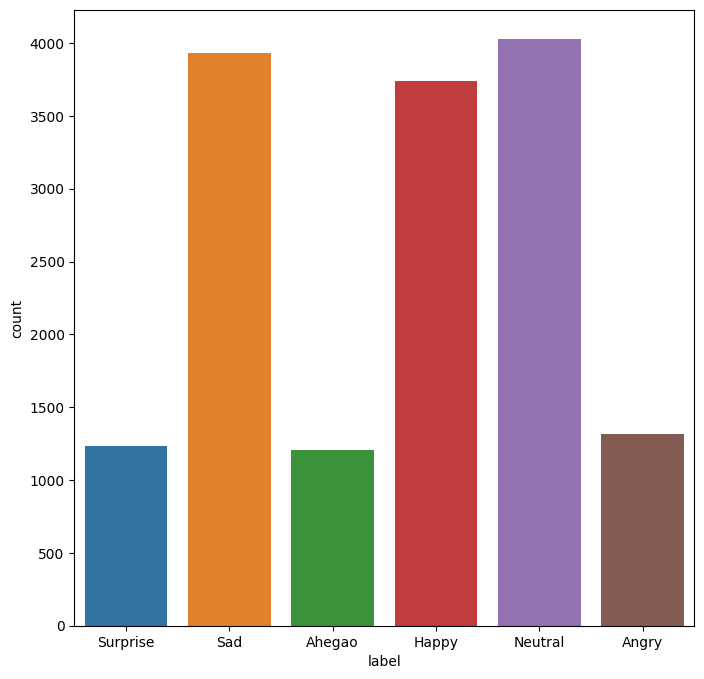

In [6]:
import seaborn as sns
plt.figure(figsize=(8,8))
sns.countplot(x = data['label'])
plt.xticks(rotation=0)
plt.show()

**STEP 3: SPLIT THE DATASET AND PERFORM NORMALIZATION**

In [7]:
target_size = (224,224)
batch_size = 64
validation_split = 0.3
train_df = image_dataset_from_directory(
    image_path,
    validation_split = validation_split,
    batch_size = batch_size,
    image_size = target_size,
    subset = 'training',
    shuffle = True,
    seed = 100
)
train_df = train_df.map(lambda x, y: (x / 255.0, y))
val_df = image_dataset_from_directory(
    image_path,
    validation_split = validation_split,
    batch_size = batch_size,
    image_size = target_size,
    subset = 'validation',
    seed = 100,
    shuffle = True
)
val_df = val_df.map(lambda x, y: (x / 255.0, y))

Found 15453 files belonging to 6 classes.
Using 10818 files for training.
Found 15453 files belonging to 6 classes.
Using 4635 files for validation.


**STEP 4: DEFINE THE MODEL**

In this step, I am using a pretrained model, ResNet152V2, as the base model. For the head, I have developed CNN two convolution layers as well as two dense layers.

In [8]:
base_model = keras.applications.ResNet152V2(include_top = False, weights = 'imagenet', input_shape = (224, 224, 3))
base_model.trainable = False
model = keras.Sequential()
model.add(base_model)
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.15))
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.15))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dropout(0.15))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(6, activation='softmax'))

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)        │ ?                      │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,331,648 (222.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 58,331,648 (222.52 MB)

**STEP 5: COMPILE THE MODEL**

In [10]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

**STEP 6: FIT THE MODEL**

In [11]:
checkpoint = ModelCheckpoint('resnet152_model_weights.keras', save_best_only = True, mode = max, monitor='val_accuracy')
earlystopping = EarlyStopping(patience = 5, restore_best_weights = True)

In [12]:
history = model.fit(
    train_df,
    epochs = 40,
    validation_data = val_df,
    callbacks = [earlystopping, checkpoint]
)

Epoch 1/40


I0000 00:00:1714916289.083140     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


170/170 ━━━━━━━━━━━━━━━━━━━━ 175s 714ms/step - accuracy: 0.4391 - loss: 1.5613 - val_accuracy: 0.6470 - val_loss: 0.9355
Epoch 2/40
170/170 ━━━━━━━━━━━━━━━━━━━━ 83s 479ms/step - accuracy: 0.5836 - loss: 1.0663 - val_accuracy: 0.6505 - val_loss: 0.9073
Epoch 3/40
170/170 ━━━━━━━━━━━━━━━━━━━━ 85s 488ms/step - accuracy: 0.6660 - loss: 0.8460 - val_accuracy: 0.6757 - val_loss: 0.8129
Epoch 4/40
170/170 ━━━━━━━━━━━━━━━━━━━━ 86s 494ms/step - accuracy: 0.7257 - loss: 0.6929 - val_accuracy: 0.6990 - val_loss: 0.7808
Epoch 5/40
170/170 ━━━━━━━━━━━━━━━━━━━━ 86s 495ms/step - accuracy: 0.7837 - loss: 0.5483 - val_accuracy: 0.7008 - val_loss: 0.7966
Epoch 6/40
170/170 ━━━━━━━━━━━━━━━━━━━━ 83s 482ms/step - accuracy: 0.8299 - loss: 0.4444 - val_accuracy: 0.6949 - val_loss: 0.8554
Epoch 7/40
170/170 ━━━━━━━━━━━━━━━━━━━━ 85s 493ms/step - accuracy: 0.8877 - loss: 0.3022 - val_accuracy: 0.7031 - val_loss: 0.9298
Epoch 8/40
170/170 ━━━━━━━━━━━━━━━━━━━━ 83s 481ms/step - accuracy: 0.9272 - loss: 0.2022 - va

**STEP 7: MODEL EVALUATION**

In [14]:
score, acc = model.evaluate(val_df)
print('Test Loss =', score)
print('Test Accuracy =', acc)

73/73 ━━━━━━━━━━━━━━━━━━━━ 24s 305ms/step - accuracy: 0.7123 - loss: 0.7515
Test Loss = 0.7808138728141785
Test Accuracy = 0.6990291476249695


In [15]:
hist_=pd.DataFrame(history.history)
hist_

,accuracy,loss,val_accuracy,val_loss
0,0.529673,1.269937,0.647033,0.935522
1,0.608245,1.011266,0.650485,0.907348
2,0.687558,0.798767,0.675728,0.812874
3,0.750324,0.643848,0.699029,0.780814
4,0.805232,0.503846,0.700755,0.796621
5,0.845997,0.409315,0.694930,0.855356
6,0.897671,0.277743,0.703128,0.929831
7,0.932890,0.188379,0.646170,1.336577
8,0.902108,0.262641,0.696009,1.082030


Hence from above, we can see that our model has achieved an accuracy of ~70% (approx.)